# <p style="text-align: center;"> RL-enhanced MBQC </p>


We want to use a RL agent to find a measurement pattern in some cluster/graph state that implements some unknown gate $U$
<img src="./assets/images/interactionDrawing.png" width="500">


Let us import some important libraries

In [1]:
import os
import gym
from gym import spaces

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import math
from scipy.stats import unitary_group
import scipy as scp
import networkx as nx

from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import CheckpointCallback, EveryNTimesteps

from stable_baselines3.common import results_plotter
from stable_baselines3.common.results_plotter import load_results, ts2xy

C:\Users\luism\anaconda3\envs\gym\lib\site-packages\ale_py\roms\__init__.py:84: DeprecationWarning: Automatic importing of atari-py roms won't be supported in future releases of ale-py. Please migrate over to using `ale-import-roms` OR an ALE-supported ROM package. To make this warning disappear you can run `ale-import-roms --import-from-pkg atari_py.atari_roms`.For more information see: https://github.com/mgbellemare/Arcade-Learning-Environment#rom-management
  __all__ = _resolve_roms()


Import the mbqc_env

In [2]:
from env_mbqc import *

# Training agents!

### One qubit gates:

In [8]:
#define our graph
gr = nx.Graph()
gr.add_nodes_from(list(range(5)))
gr.add_edges_from([(0, 1),(1,2),(2,3),(3,4)])

#pick a one-qubit unitary gate to learn
unitary_random = unitary_group.rvs(2)

In [9]:
#create environment and path for log file
env = mbqc_env(4, 1, gr, lambda x: x+1, unitary_random, noise=0, noise_type="none" ,test_fidelity=False, init_state_random = True)
log_dir = "./logs/"
os.makedirs(log_dir, exist_ok=True)
env = Monitor(env, log_dir)
checkpoint_on_event = CheckpointCallback(save_freq=1, save_path='./logs/')
event_callback = EveryNTimesteps(n_steps=1000, callback=checkpoint_on_event)

In [10]:
#define and train the model
model = PPO("MlpPolicy", env, verbose=0);
model.learn(total_timesteps=int(1e5), callback=event_callback);

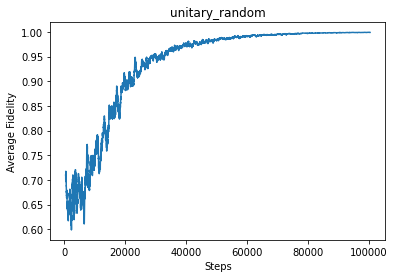

In [11]:
plot_results(log_dir, title="unitary_random",w=100)

### Two qubit gates:

In [16]:
#Define graph topology
gr = nx.Graph()
gr.add_nodes_from(list(range(14)))
gr.add_edges_from([(0, 1), (1, 2), (2,3), (3,4),(4,5),
                   (6,1), (6,5),(6,7),(7,12), (5,8),(8,9),(9,10),(10,11),(11,13)])

#Define flow on graph gr
def flow_function(i):
    output = 0
    if i==7:
        output=12
    elif i==5:
        output=8
    elif i==11:
        output=13
    else:
        output = i+1
    return output

#Pick any 2-qubit gate:
unitary_random2 = unitary_group.rvs(4)

In [17]:
env2 = mbqc_env(12, 2, gr, flow_function, unitary_random2, noise=0, noise_type="none" ,test_fidelity=False, init_state_random = True)

log_dir2 = "./logs2/"
os.makedirs(log_dir2, exist_ok=True)
env2 = Monitor(env2, log_dir2)

checkpoint_on_event = CheckpointCallback(save_freq=1, save_path='./logs/')
event_callback = EveryNTimesteps(n_steps=1000, callback=checkpoint_on_event)

In [ ]:
#Define and train the agent
model2 = PPO("MlpPolicy", env2, verbose=0)
model2.learn(total_timesteps=int(5e5), callback=event_callback)

In [ ]:
plot_results(log_dir2, title="unitary_random2",w=100)

## Performance of agent trained with noisy data:

In [ ]:
def get_noisy_data(noise_type):
    random_noise_data = []
    for noise_strength in np.linspace(0,1,30):
        env = measurement_env(4,H, noise=noise_strength ,noise_type = noise_type, test_fidelity=False)
        log_dir = "./logs/"
        os.makedirs(log_dir, exist_ok=True)
        env = Monitor(env, log_dir)

        checkpoint_on_event = CheckpointCallback(save_freq=1, save_path='./logs/')
        event_callback = EveryNTimesteps(n_steps=1000, callback=checkpoint_on_event)
        model = PPO("MlpPolicy", env, verbose=0)
        model.learn(total_timesteps=int(5e4), callback=event_callback)

        values = np.array([])
        env = measurement_env(4,H, noise=noise_strength, test_fidelity=True)
        for i in range(100):
            obs = env.reset()
            done = False
            while not done:
                action, states = model.predict(obs, deterministic=True)
                obs, reward, done, info = env.step(action)
                if done:
                    values = np.append(values, [reward])
        env.close()
        random_noise_data.append(values)
    return random_noise_data

def mean_and_std_data(data):
    random_data_mean = []
    random_data_std = []
    for (indx,i) in enumerate(range(len(random_noise_data))):
        random_data_mean.append(np.mean(random_noise_data[indx]))
        random_data_std.append(np.std(random_noise_data[indx]))
    return random_data_mean,random_data_std

#### 1) Random noise in training data

In [ ]:
random_noise_data = get_noisy_data("random")
random_data_mean,random_data_std = mean_and_std_data(random_noise_data)

plt.errorbar(np.linspace(0,1,30), random_data_mean, yerr= random_data_std, c='b', marker='.', label=r"$F \pm \sigma$")
plt.legend(loc=4)
plt.xlabel("Noise strength")
plt.ylabel("Average fidelity")
plt.ylim(0.3,1.09)
plt.title("Random noise model")
plt.show()

#### 2) Bitflip error channel on training data

In [ ]:
bitflip_noise_data = get_noisy_data("bitflip")
bitflip_data_mean, bitflip_data_std = mean_and_std_data(bitflip_noise_data)

plt.errorbar(np.linspace(0,1,30), bitflip_data_mean, yerr= bitflip_data_std, c='b', marker='.', label=r"$F \pm \sigma$")
plt.legend(loc=3)
plt.xlabel("Error probability")
plt.ylabel("Average fidelity")
plt.ylim(0.1,1.1)
plt.title("Bitflip noise model")
plt.show()